In [39]:
import pandas as pd
import os
import re
from matplotlib import pyplot as plt
import numpy as np

### The goal is to perform analysis on the repetitiveness of the A artists

In [2]:
! ls

a_artist_repetitiveness.ipynb
infgen
lyrics.nosync
lyrics_repetitiveness_analysis-Copy1.ipynb
lyrics_repetitiveness_analysis.ipynb
output_files
run_infgen
working_files


In [3]:
a_data = pd.read_csv('lyrics.nosync/a_tracks.csv')

In [4]:
a_data.head()

,ISRC,SPOTIFY_ID,TITLE,ARTIST,song_id,POP,lyrics,producer,writer
0,USCM51800207,0h1W19pS59KtEd7aDzF58i,In My Feelings,Drake,3807759,100,"\n\n[Intro: Drake]\nTrap, TrapMoneyBenny\nThis...","['TrapMoneyBenny', 'BlaqNmilD']","['Phillip Price', 'Orville Hall', 'Magnolia Sh..."
1,USCM51800078,7liAO2OqrFMVvM7oiLo0m0,Nice For What,Drake,3580132,100,\n\n[Intro: Big Freedia]\nI wanna know who mot...,"['BlaqNmilD', 'Murda Beatz']","['The Showboys', 'Lauryn Hill', 'Loon', 'Orvil..."
2,USCM51800005,61T2H6w0ggQdhCvVegLl99,God's Plan,Drake,3315890,100,"\n\n[Intro]\nYeah, they wishin' and wishin' an...","['Cardo', 'Yung Exclusive', 'Boi-1da']","['Brock Korsan', 'Cardo', 'Yung Exclusive', '4..."
3,USUM71713011,6ZMbykUu07aL2Drx988zAq,River (feat. Ed Sheeran),Eminem,3384370,98,\n\n[Refrain: Ed Sheeran]\nIch bin ein Lügner ...,[],[]
4,USUM71805289,5SxkdsY1ufZzoq9iXceLw9,no tears left to cry,Ariana Grande,3649172,98,"\n\n[Intro]\nRight now, I'm in a state of mind...","['Ilya Salmanzadeh', 'Max Martin']","['Ilya Salmanzadeh', 'Savan Kotecha', 'Max Mar..."


In [7]:
a_data.shape

(173, 9)

In [8]:
a_data.ISRC.duplicated().any()

False

In [9]:
lyrics = a_data[['song_id', 'lyrics']]

In [10]:
#Convert each lyrics to a separate text file
for index, row in lyrics.iterrows():
    lyrics_data = row.lyrics
    song_id = row.song_id

    with open('working_files_a/'+str(song_id)+'.txt', 'w') as f:
        f.write(lyrics_data)

In [ ]:
### in command line run gzip all files in working_files_a -- gzip -r .

In [ ]:
### in command line run command to obtain stats from zipped files using infgen

In [13]:
# Find all files outputed by infgen
out_files = [f for f in os.listdir('output_files_a/') if f.endswith('.txt')]

In [20]:
# Find compression ratios
ids = []
compression_ratios = []

for file in out_files:
    ratio = ratio_by_file(file)
    compression_ratios.append(ratio)
    file_id = file.split('.')[0]
    ids.append(file_id)

In [21]:
ratio_by_file = pd.DataFrame()
ratio_by_file['song_id'] = ids
ratio_by_file['repetition_share'] = compression_ratios

In [22]:
ratio_by_file.head()

,song_id,repetition_share
0,3105301,0.517522
1,3549261,0.565299
2,3636162,0.314286
3,3178019,0.598101
4,3013669,0.613069


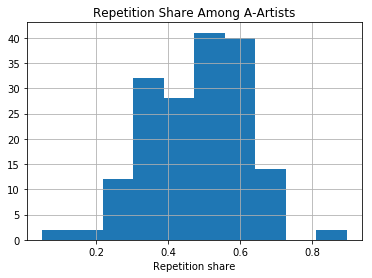

In [27]:
ratio_by_file.repetition_share.hist()
plt.title('Repetition Share Among A-Artists')
plt.xlabel('Repetition share')
plt.show()

In [32]:
ratio_by_file['song_id'] = ratio_by_file.song_id.map(lambda x: int(x))

In [33]:
merged = a_data.merge(ratio_by_file, on='song_id', how='inner')

In [60]:
repetition_by_artist = merged.groupby('ARTIST')['repetition_share'].mean().sort_values()

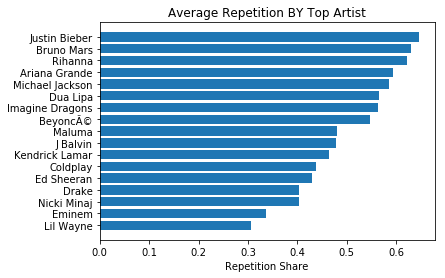

In [63]:
plt.barh(np.arange(0,len(repetition_by_artist)), repetition_by_artist.values)
plt.yticks(np.arange(0,len(repetition_by_artist)),repetition_by_artist.index)
plt.xlabel('Repetition Share')
plt.title('Average Repetition BY Top Artist')
plt.show()

In [67]:
merged.to_csv('lyrics.nosync/repetition_a_artists.csv', index=False)

In [17]:
def parse_ratio(f):
    '''Determine the compression ratio as a proxy of song repetitiveness'''
    matches = 0
    n_literals = 0
    n_symbols = 0
    uncomp = 0
    
    for line in f:
        if line.startswith('match'):
            _, length, dist = line.split()
            matches += 1

        pattern = r'! stats literals \d\.\d bits each \(\d+/(\d+)\)'
        p = re.compile(pattern)
        m = re.match(p, line)
        if m:
            n_literals = int(m.group(1))

        m = re.match(r'! stats total inout \d+:\d+ \((\d+)\)', line)
        if m:
            n_symbols = int(m.group(1))

        m = re.match(r'! stats total block average (\d+)\.\d uncompressed', line)
        if m:
            uncomp = int(m.group(1))

    assert matches + n_literals == n_symbols

    # 1 byte per literal, 3 bytes per match.
    pseudosize = matches * 3 + n_literals
    ratio = 1 - pseudosize / uncomp

    return ratio

def ratio_by_file(filename):
    '''Read in file and return compression ratio'''
    
    df = pd.read_table('output_files_a/' + filename)
    df.columns = ['infgen']
    inp = df.infgen.tolist()
    
    ratio = parse_ratio(inp)
    
    return ratio